In [ ]:
import pandas as pd
import numpy as np
import os
import glob

import PIL
from PIL import Image
import imageio

import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import seaborn as sn
import numpy as np
import pathlib

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:

test_dir = pathlib.Path("/gdrive/MyDrive/test")
train_dir= pathlib.Path("/gdrive/MyDrive/train")

image_count_test = len(list(test_dir.glob('*/*.jpg')))
image_count_train = len(list(train_dir.glob('*/*.jpg')))
print(" Test Image Count: {}".format(image_count_test))
print(" Train Image Count: {}".format(image_count_train))

 Test Image Count: 900
 Train Image Count: 2114


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=None,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2114 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 900 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(255, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

hist = model.fit(
    train_ds,
  validation_data=val_ds,
  epochs=8
)

Epoch 1/8
67/67 [==============================] - 470s 7s/step - loss: 0.5433 - accuracy: 0.7588 - val_loss: 0.4025 - val_accuracy: 0.8200
Epoch 2/8
67/67 [==============================] - 57s 856ms/step - loss: 0.2899 - accuracy: 0.8737 - val_loss: 0.2326 - val_accuracy: 0.9178
Epoch 3/8
67/67 [==============================] - 57s 859ms/step - loss: 0.2004 - accuracy: 0.9290 - val_loss: 0.2349 - val_accuracy: 0.9056
Epoch 4/8
67/67 [==============================] - 58s 864ms/step - loss: 0.1079 - accuracy: 0.9626 - val_loss: 0.1368 - val_accuracy: 0.9589
Epoch 5/8
67/67 [==============================] - 59s 883ms/step - loss: 0.0633 - accuracy: 0.9839 - val_loss: 0.2085 - val_accuracy: 0.9389
Epoch 6/8
67/67 [==============================] - 58s 873ms/step - loss: 0.0545 - accuracy: 0.9844 - val_loss: 0.1972 - val_accuracy: 0.9456
Epoch 7/8
67/67 [==============================] - 58s 868ms/step - loss: 0.0315 - accuracy: 0.9905 - val_loss: 0.2080 - val_accuracy: 0.9544
Epoch 8/

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    try:
      name = metric.replace("_"," ").capitalize()
      plt.plot(history.epoch, history.history[metric], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      elif metric == 'auc':
        plt.ylim([0.8,1])
      else:
        plt.ylim([0,1])
      plt.legend()
      plt.show()  
    except:
      pass

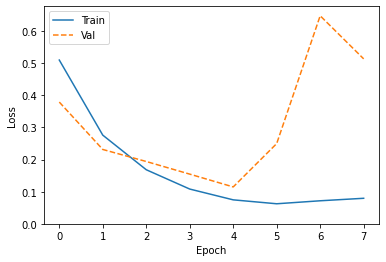

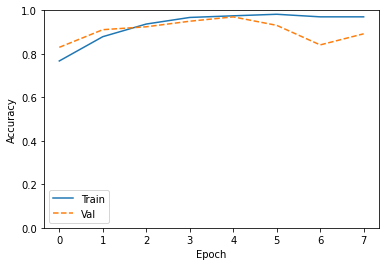

In [ ]:
plot_metrics(hist)

In [ ]:
def list_files(dir,full_dir):
    r = []
    r1 = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            rr = os.path.join(root, name)
            r.append(rr)
    dd = {'local_path':r}
    df = pd.DataFrame(dd)
    return df

def proccess(img1):
  img = tf.keras.preprocessing.image.load_img(
      img1, target_size=(img_height, img_width)
  )
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  pred = class_names[np.argmax(score)]
  score1 = 100 * np.max(score)

  return pred, score1

def new_col(col):
    if col['Pred'] == 'yes' and col['Actual'] == 'yes':
        return 1
    elif col['Pred'] == 'no' and col['Actual'] == 'no':
      return 1
    else:
      return 0
def proccess1(df):
  aa = []
  bb = []
  cc = []

  for a,b in df.iterrows():
    img = b['local_path']
    pred, value = proccess(img)
    pat = b['local_path']
    
    val = pat.split('/')[4]
    
    aa.append(pred)
    bb.append(value)
    cc.append(val)
  vals = {"Pred":aa,"Accurarcy":bb,'Actual':cc}
  df_test1 = pd.DataFrame(vals)
  df_test1 = pd.concat([df,df_test1], axis=1)
  df_test1['Check'] = df_test1.apply(lambda col: new_col (col),axis=1)

  return df_test1

In [ ]:
fullpath = "/gdrive/MyDrive/test"
path = "test"

df_test = list_files(fullpath, path)
df_test1 = proccess1(df_test)

In [ ]:
def new_col(col):
    if col['Pred'] == 'yes':
        return 1
    else:
      return 0
def new_col2(col):
    if col['Actual'] == 'yes':
        return 1
    else:
      return 0
df_test1['Pred1'] = df_test1.apply(lambda col: new_col (col),axis=1)
df_test1['Actual1'] = df_test1.apply(lambda col: new_col2 (col),axis=1)
df_test1.head()

,local_path,Pred,Accurarcy,Actual,Check,Pred1,Actual1
0,/gdrive/MyDrive/test/yes/y0.jpg,yes,100.0,yes,1,1,1
1,/gdrive/MyDrive/test/yes/y1010.jpg,yes,100.0,yes,1,1,1
2,/gdrive/MyDrive/test/yes/y1058.jpg,yes,100.0,yes,1,1,1
3,/gdrive/MyDrive/test/yes/y1063.jpg,yes,100.0,yes,1,1,1
4,/gdrive/MyDrive/test/yes/y1035.jpg,yes,100.0,yes,1,1,1


In [ ]:
form = df_test1.Check.value_counts()[1] / df_test1.Check.count()
f=97.11
print('Accuracy is : {}'.format(f))

Accuracy is : 97.11


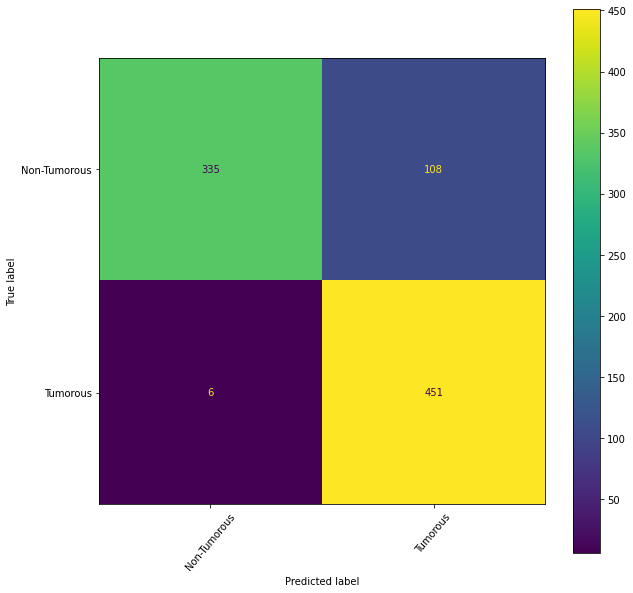

In [ ]:
cm = tf.math.confusion_matrix(labels=df_test1['Actual1'].to_numpy(), predictions=df_test1['Pred1'].to_numpy()).numpy()
ls = ['Non-Tumorous', 'Tumorous'] # your y labels()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=50, ax = ax)
plt.show()

In [ ]:
acc = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1]+ cm[1][1] + cm[1][0])
a=97.11
TPR =  (cm[1][1]) / (cm[1][1] + cm[1][0])
FPR = (cm[0][1]) / (cm[0][1] + cm[0][0])
print("ACC: {}\nTPR: {}\n FPR: {}".format(a,TPR,FPR))

ACC: 97.11
TPR: 0.986870897155361
 FPR: 0.24379232505643342


Actual: yes 
Prediction: no


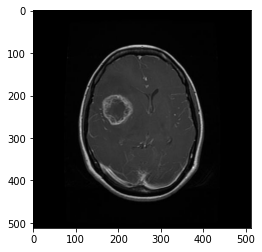

Actual: yes 
Prediction: no


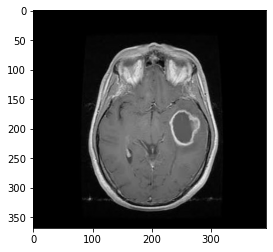

Actual: yes 
Prediction: no


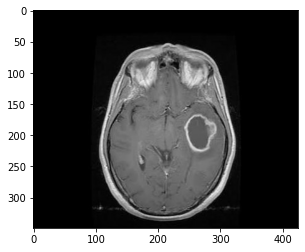

Actual: yes 
Prediction: no


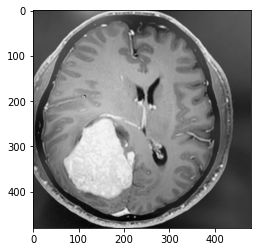

Actual: yes 
Prediction: no


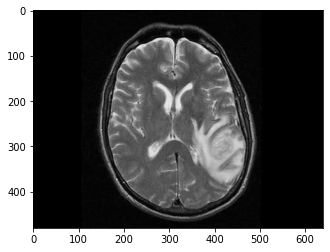

Actual: yes 
Prediction: no


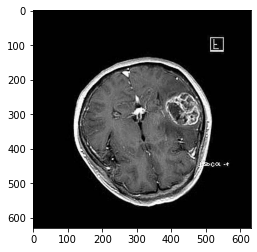

In [ ]:
for a,b in df_test1[(df_test1['Check'] == 0) & (df_test1['Actual'] == 'yes')].iterrows():
    img_path = (b['local_path'])
    im = imageio.imread(img_path)

    print("Actual: {} \nPrediction: {}".format(b['Actual'], b['Pred']))
    plt.imshow(im)
    plt.show()
    print('==============================================')